In [1]:
import os
if os.path.basename(os.path.abspath(".")) == "notebooks":
    os.chdir("..")

import argparse
import random
import shutil
import pprint
import time
import os
import cv2
import json
import pickle
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import datetime
import torchvision
from tqdm import tqdm
from PIL import Image
from einops import rearrange
from torchvision.utils import make_grid
import torch
from torch import autocast
from contextlib import contextmanager, nullcontext
from src.datasets import get_dataset
from src.foreground_masks import GMMMaskSuggestor
from src.preliminary_masks import preprocess_attention_maps
from src.visualization.utils import word_to_slice
from src.visualization.utils import MIMIC_STRING_TO_ATTENTION
from src.visualization.utils import model_to_viz
from log import logger, log_experiment
from sklearn.metrics import jaccard_score
from log import logger, log_experiment
from log import formatter as log_formatter
from tqdm import tqdm
import logging
from utils import get_compute_mask_args, make_exp_config, load_model_from_config, collate_batch, img_to_viz
from einops import reduce, rearrange, repeat
from pytorch_lightning import seed_everything
from mpl_toolkits.axes_grid1 import ImageGrid
from omegaconf import OmegaConf
from src.ldm.util import instantiate_from_config
from src.ldm.util import AttentionSaveMode
from src.ldm.models.diffusion.plms import PLMSSampler
from src.preliminary_masks import reorder_attention_maps, normalize_attention_map_size
from src.ldm.models.diffusion.ddim import DDIMSampler
from src.evaluation.utils import compute_metrics, compute_prediction_from_binary_mask
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import matplotlib.patches as patches
from src.datasets.utils import path_to_tensor
from src.ldm.encoders.modules import OpenClipDummyTokenizer

/vol/ideadata/ed52egek/conda/chest/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_latent_slice(batch, opt):
    ds_slice = []
    for slice_ in batch["slice"]:
        if slice_.start is None:
            ds_slice.append(slice(None, None, None))
        else:
            ds_slice.append(slice(slice_.start // opt.f, slice_.stop // opt.f, None))
    return tuple(ds_slice)

def apply_rect(img, x, y, h, w, color="red"):
    img = (img * 255).to(torch.uint8).numpy()
    img = rearrange(img, "c h w -> h w c")
    if color == "red":
        color = (255, 0, 0)
    elif color == "blue":
        color = (0, 0, 255)

    img = cv2.rectangle(img.copy(), [x, y], [x + h, y + w], color, 3)
    img = rearrange(img, "h w c -> c h w") / 255.
    return torch.tensor(img)


def add_viz_of_data_and_pred(images, batch, x_samples_ddim, opt):
    # append input
    x0_norm = torch.clamp((batch["x"] + 1.0) / 2.0, min=0.0, max=1.0).cpu()
    x0_norm = reduce(x0_norm, 'b c (h h2) (w w2) -> b c h w', 'mean', h2=opt.f, w2=opt.f)
    images.append(x0_norm)

    # append model output

    x_samples_ddim = torch.clamp((x_samples_ddim + 1.0) / 2.0, min=0.0, max=1.0).cpu()
    images.append(
        reduce(x_samples_ddim, 'b c (h h2) (w w2) -> b c h w', 'mean', h2=opt.f, w2=opt.f))

    # append gt mask
    images.append(
        reduce(batch["segmentation_x"], 'b c (h h2) (w w2) -> b c h w', 'max', h2=opt.f, w2=opt.f))


def contrast_to_noise_ratio(ground_truth_img, prelim_mask_large):
    gt_mask = ground_truth_img.flatten()
    pr_mask = prelim_mask_large.flatten()

    roi_values = pr_mask[gt_mask == 1.0]
    not_roi_values = pr_mask[gt_mask != 1.0]

    contrast = roi_values.mean() - not_roi_values.mean()
    noise = torch.sqrt(
        roi_values.var() / 2 + not_roi_values.var() / 2
    )
    cnr = contrast / noise
    return cnr


def check_mask_exists(mask_dir, samples):
    for i in range(len(samples["rel_path"])):
        path = os.path.join(mask_dir, samples["rel_path"][i] + ".pt")
        if not os.path.exists(path):
            return False
    return True

# Important Variables

In [3]:
log_dir = "notebooks/outputs/multi_class_segmentation/"
EXP_PATH = "experiments/chestxray/train_multilabel_hpc_arm01_ft.py"
#MODEL_PATH = "/vol/ideadata/ed52egek/diffusionmodels/chest/arm/mlf-false-true-1-5e5-30000.ckpt"
MODEL_PATH = "/vol/ideadata/ed52egek/diffusionmodels/chest/arm/mlf-false-true-0-5e5-30000.ckpt"
os.makedirs(log_dir, exist_ok=True)
opt = make_exp_config(EXP_PATH)


# Load Model

In [4]:
opt.dataset_args_test["base_dir"] = opt.dataset_args_test["base_dir"].replace("/home/atuin/b143dc/b143dc11/", "/vol/ideadata/ed52egek/")
dataset = get_dataset(opt, "test")
print(f"Dataset length: {len(dataset)}")

print(opt.config_path)
config = OmegaConf.load(f"{opt.config_path.replace('/home/atuin/b143dc/b143dc11', '/vol/ideadata/ed52egek')}")
config["model"]["params"]["use_ema"] = False
config["model"]["params"]["unet_config"]["params"]["attention_save_mode"] = "cross"
logger.info(f"Enabling attention save mode")

is_mlf = False
if hasattr(opt, "mlf_args"):
    is_mlf = opt.mlf_args.get("multi_label_finetuning", False)
    logger.info(f"Overwriting default arguments of config with {opt.mlf_args}")
    config["model"]["params"]["attention_regularization"] = opt.mlf_args.get("attention_regularization")
    config["model"]["params"]["cond_stage_key"] = opt.mlf_args.get("cond_stage_key")
    config["model"]["params"]["cond_stage_config"]["params"]["multi_label_finetuning"] = opt.mlf_args.get("multi_label_finetuning")

model = load_model_from_config(config, f"{MODEL_PATH}")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)
dataset.load_precomputed(model)
sampler = DDIMSampler(model)

Dataset length: 1133
/home/atuin/b143dc/b143dc11/pycharm/chest-distillation/experiments/chestxray/configs/v2-chest-training.yaml
2023-02-28 23:04:18,075 | 966120560.py-<module>-0009 | INFO | Enabling attention save mode
2023-02-28 23:04:18,076 | 966120560.py-<module>-0014 | INFO | Overwriting default arguments of config with {'multi_label_finetuning': True, 'cond_stage_key': 'finding_labels', 'append_invariance_tokens': False, 'single_healthy_class_token': True, 'attention_regularization': 0.0}
Loading model from /vol/ideadata/ed52egek/diffusionmodels/chest/arm/mlf-false-true-0-5e5-30000.ckpt
Global Step: 30000
No module 'xformers'. Proceeding without it.
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 865.91 M params.
2023-02-28 23:04:44,704 | ddpm.py-__init__-0142 | INFO | Unconditional guidance probability: 0.0
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with

# Filter for duplicate bounding box entries

In [5]:
dicom_ids = dict()
for i in range(len(dataset)):
    dicom_id = dataset[i]["dicom_id"]
    if dicom_ids.get(dicom_id) is None:
        dicom_ids[dicom_id] = []
    dicom_ids[dicom_id].append(i)

duplicat_entries = {}
for k, v in dicom_ids.items():
    if len(v) >= 2:
        duplicat_entries[k] = v

In [6]:
duplicat_entries

{'10742c3a-7a53c874-504c91b3-4edf52b6-63e07a65': [41, 42],
 '263f4b49-a7acda12-ac09e200-38c1abb6-c8f1a736': [59, 60],
 '30fe40e1-ab514475-aa387b0a-e1718b1b-ba680a97': [71, 72],
 '5209cbae-fb03f881-a574bc73-1650ad4b-d98ba5d7': [88, 89],
 '24dcc6bd-268da180-8371ae76-64cd7bcd-550a8701': [144, 145],
 '649af982-e3af4e3a-75013d30-cdc71514-a34738fd': [159, 160],
 '2ffb00ee-7e6e8162-ea10e2d6-775a8c0b-2740a4fe': [182, 183],
 '24d2c2c6-e4726d3f-b0dbec5f-e9cc089b-48540d67': [189, 190],
 '167bfa4f-ff65ca7b-83a2e6dd-73ed4d62-c091ad56': [242, 243],
 '2f22b153-f24ed6db-360ecabd-dcae4df5-7abbaeb9': [283, 284],
 '3eb2c7f8-1c178075-437d2500-02dbf9a2-c8d83b59': [293, 294],
 '2bbed805-9edabe38-d0476a90-21720847-53aa7ab7': [304, 305],
 '2f1c35dd-87dba75e-8e130c33-fa4599a2-b2e62843': [320, 321, 322],
 '66803d25-8cd70ad7-5c433c69-ed2f0f5b-f136a8e9': [341, 342],
 'eeedc8ef-a2ac3f2b-db1cd3f4-6ab2922e-ae93a7f8': [367, 368],
 '816988b6-f2c33f81-3e6f44f0-8ad131a8-c1749797': [370, 371],
 '92666ac1-70ccc2f3-66bc3d4

In [7]:
tokenizer = OpenClipDummyTokenizer(opt.seed, opt.mlf_args.get("append_invariance_tokens", False), opt.mlf_args.get("single_healthy_class_token", False))
model.cond_stage_model.set_multi_label_tokenizer(tokenizer)

In [8]:
precision_scope = autocast
rev_diff_steps = 40

duplicat_entrie = duplicat_entries[[*duplicat_entries.keys()][0]]
entries = [dataset[i] for i in duplicat_entrie]
entries[0].keys()
input_conditions = "|".join([entrie["finding_labels"] for entrie in entries])

dm_input = {}
dm_input["finding_labels"] = [input_conditions,]
dm_input["img"] = entries[0]["img"]
dm_input["bbox_img"] = [entries[i]["bbox_img"] for i in range(len(entries))]
with torch.no_grad():
    with precision_scope("cuda"):
        with model.ema_scope():
            images = model.log_images(dm_input, N=1, split="test", sample=False, inpaint=True,
                              plot_progressive_rows=False, plot_diffusion_rows=False,
                              use_ema_scope=False, cond_key="finding_labels", mask=1.,
                              save_attention=True)
            attention_maps = images.pop("attention")
            attention_images = preprocess_attention_maps(attention_maps, on_cpu=False)



Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0


In [9]:
attention = attention_images[0]
token_positions = tokenizer.get_attention_map_location(dm_input["finding_labels"][0].split("|"))
#for token_position in token_positions:
#    tok_attention = attention[-1 * rev_diff_steps:, :,
#                    token_position:token_position+ 1]
#    tok_attentions.append(tok_attention.mean(dim=(0, 1, 2)))
print(token_positions)
attention = attention[-rev_diff_steps:,].mean(dim=(0,1))
assert len(attention) == 9
labels = [[*tokenizer.MAPPING[i].keys()][0] for  i in range(len(tokenizer.MAPPING))]

[7, 8]


<BarContainer object of 9 artists>

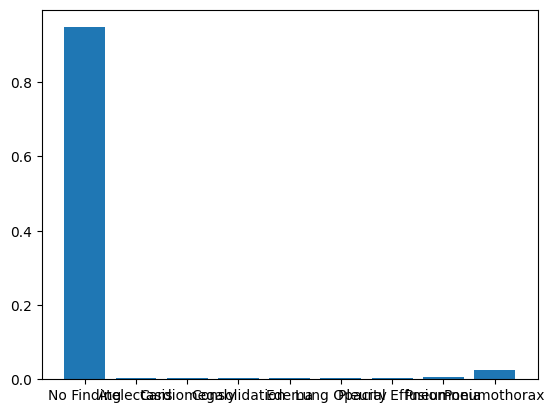

In [10]:
plt.bar(labels, attention.mean(dim=(1,2)).cpu())

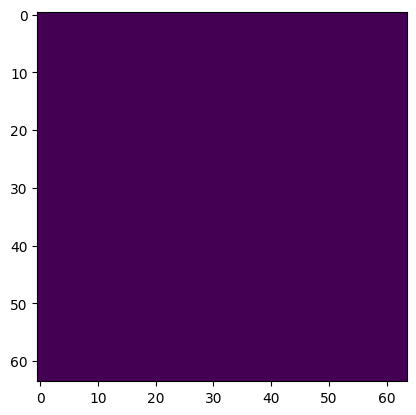

In [11]:
plt.imshow(attention[1:].argmax(dim=0).cpu()/8*255)

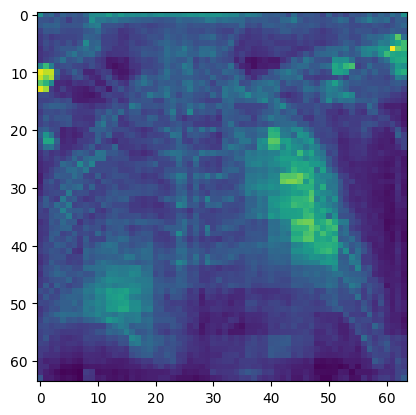

In [12]:
plt.imshow(attention[7].cpu())

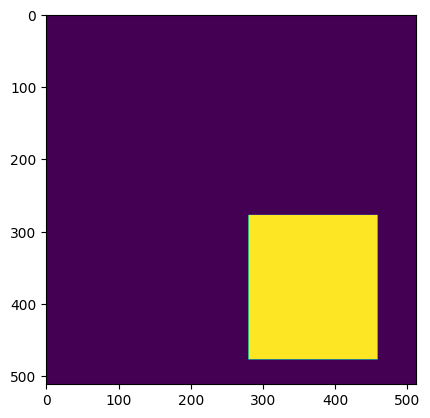

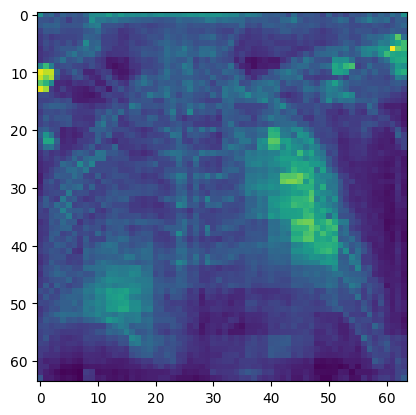

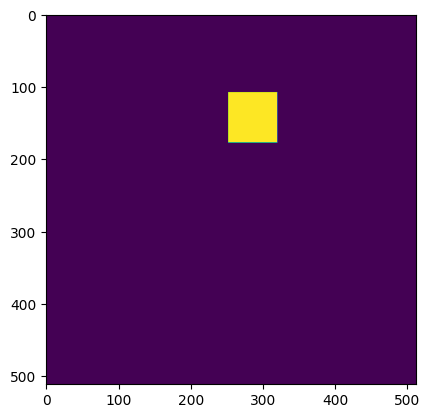

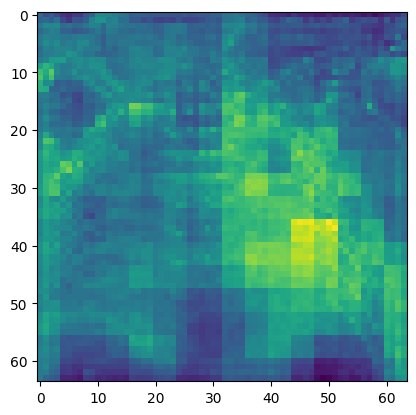

In [13]:
plt.imshow(dm_input["bbox_img"][0])
plt.show()
plt.imshow(attention[token_positions[0]].cpu())
plt.show()
plt.imshow(dm_input["bbox_img"][1])
plt.show()
plt.imshow(attention[token_positions[1]].cpu())
plt.show()


In [14]:
attention[1:].argmax(dim=0).max()
#plt.imshow()

tensor(7, device='cuda:0')